# Expected Value Framework for ML Decision Making

This notebook demonstrates a **business-oriented optimization** approach for classification threshold optimization using the expected value framework. We'll explore how to align machine learning model outputs with business objectives rather than just statistical accuracy.

## Table of Contents
1. [Expected Value Framework Fundamentals](#1-expected-value-framework-fundamentals)
2. [Email Marketing Campaign Use Case](#2-email-marketing-campaign-use-case)
3. [Data Generation and Model Setup](#3-data-generation-and-model-setup)
4. [Mapping Predictions to Business Impact](#4-mapping-predictions-to-business-impact)
5. [Threshold Optimization via Expected Value](#5-threshold-optimization-via-expected-value)
6. [Customer Personalization using EV Framework](#6-customer-personalization-using-ev-framework)
7. [Global Thresholding vs Personalization Comparison](#7-global-thresholding-vs-personalization-comparison)
8. [Policy Evaluation](#8-policy-evaluation)
9. [Conclusions](#9-conclusions)

## 1. Expected Value Framework Fundamentals

In probability theory, the **expected value** (EV) of a random variable is the **long-run average** of outcomes weighted by their probabilities:

$$
\mathbb{E}[X] = \sum_{i} P(y_i) \cdot V(y_i)
$$

Where:
- $ y_i $: possible class label or outcome (e.g., 0 or 1 in binary classification)  
- $ P(y_i) $: predicted probability of class $ y_i $  
- $ V(y_i) $: business benefit or cost associated with class $ y_i $

This framework helps bridge predictions and real-world decision-making by accounting for both **uncertainty** and **impact**.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.calibration import CalibratedClassifierCV
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

## 2. Email Marketing Campaign Use Case

In email marketing, there's always a risk that customers will unsubscribe or mark emails as spam if they receive too many promotional messages. The **goal** of our ML model is to predict whether a customer will unsubscribe from the mailing list if they receive a promotional email.

**Model Definition:**
- **Label 0**: Customer will *not* unsubscribe → good candidate to **send email**
- **Label 1**: Customer will *unsubscribe* → should **not send email**

**Confusion Matrix Interpretation:**

| Case | Prediction | Actual | Action Taken | Outcome Type | Business Impact |
|------|------------|--------|--------------|--------------|----------------|
| ✅ True Positive (TP) | 1 | 1 | Don't send email | Correct action | Avoided sending to unsubscriber |
| ❌ False Positive (FP) | 1 | 0 | Don't send email | Missed opportunity | Wrongly withheld from engaged customer |
| ❌ False Negative (FN) | 0 | 1 | Send email | Incorrect action | Sent email to unsubscriber |
| ✅ True Negative (TN) | 0 | 0 | Send email | Correct action | Successfully sent to engaged customer |

## 3. Data Generation and Model Setup

Let's create a synthetic dataset that mimics real email marketing data with customer features and unsubscribe behavior.

In [2]:
def generate_email_marketing_data(n_samples=150000, random_state=42):
    """
    Generate synthetic email marketing dataset with realistic customer features.
    
    Features include:
    - Customer demographics (age, tenure)
    - Engagement metrics (email_opens, click_rate)
    - Purchase behavior (total_spent, recent_purchases)
    - Email frequency preferences
    """
    np.random.seed(random_state)
    
    # Generate customer features
    data = {
        'customer_id': range(1, n_samples + 1),
        'age': np.random.normal(35, 12, n_samples).clip(18, 80),
        'tenure_months': np.random.exponential(24, n_samples).clip(1, 120),
        'email_opens_last_30d': np.random.poisson(8, n_samples),
        'click_rate': np.random.beta(2, 8, n_samples),  # Skewed towards lower values
        'total_spent_lifetime': np.random.lognormal(4, 1.5, n_samples),
        'purchases_last_90d': np.random.poisson(2, n_samples),
        'avg_order_value': np.random.lognormal(3, 0.8, n_samples),
        'email_frequency_preference': np.random.choice([1, 2, 3, 4], n_samples, p=[0.1, 0.3, 0.4, 0.2]),
        'segment': np.random.choice(['high_value', 'medium_value', 'low_value', 'new_customer'], 
                                  n_samples, p=[0.15, 0.35, 0.35, 0.15])
    }
    
    df = pd.DataFrame(data)
    
    # Create interaction features
    df['engagement_score'] = (df['email_opens_last_30d'] * df['click_rate'] * 
                             (1 + df['purchases_last_90d'] / 10))
    df['value_per_month'] = df['total_spent_lifetime'] / df['tenure_months']
    df['recency_score'] = np.exp(-df['tenure_months'] / 24)  # Decay function
    
    # Generate unsubscribe probability based on features (realistic relationships)
    unsubscribe_logit = (
        -2.5 +  # Base low unsubscribe rate
        -0.5 * df['engagement_score'] +  # High engagement reduces unsubscribe risk
        -0.3 * (df['email_frequency_preference'] == 4) +  # High freq preference reduces risk
        +0.4 * (df['email_frequency_preference'] == 1) +  # Low freq preference increases risk
        -0.2 * np.log1p(df['purchases_last_90d']) +  # Recent purchases reduce risk
        +0.1 * (df['click_rate'] < 0.1) +  # Very low click rate increases risk
        -0.15 * (df['segment'] == 'high_value') +  # High value customers less likely to unsubscribe
        +0.2 * (df['segment'] == 'new_customer') +  # New customers more uncertain
        np.random.normal(0, 0.3, n_samples)  # Add noise
    )
    
    # Convert to probabilities and generate labels
    unsubscribe_prob = 1 / (1 + np.exp(-unsubscribe_logit))
    df['will_unsubscribe'] = np.random.binomial(1, unsubscribe_prob)
    
    # One-hot encode categorical variables
    df = pd.get_dummies(df, columns=['segment'], prefix='segment')
    
    return df

# Generate the dataset
df = generate_email_marketing_data()
print(f"Dataset shape: {df.shape}")
print(f"Unsubscribe rate: {df['will_unsubscribe'].mean():.1%}")
df.head()

Dataset shape: (150000, 17)
Unsubscribe rate: 3.3%


,customer_id,age,tenure_months,email_opens_last_30d,click_rate,total_spent_lifetime,purchases_last_90d,avg_order_value,email_frequency_preference,engagement_score,value_per_month,recency_score,will_unsubscribe,segment_high_value,segment_low_value,segment_medium_value,segment_new_customer
0,1,40.960570,15.484230,8,0.175934,10.885618,0,21.294933,3,1.407472,0.703013,0.524570,1,False,False,False,True
1,2,33.340828,39.969596,10,0.058560,58.126892,3,48.876644,4,0.761279,1.454278,0.189115,0,False,True,False,False
2,3,42.772262,27.445451,10,0.009600,54.721343,3,12.628022,2,0.124803,1.993822,0.318682,0,False,True,False,False
3,4,53.276358,10.670292,10,0.073061,322.255614,1,4.670645,2,0.803672,30.201200,0.641084,0,False,True,False,False
4,5,32.190160,1.127054,13,0.151259,12.544906,1,46.684497,2,2.163007,11.130701,0.954125,0,False,False,True,False


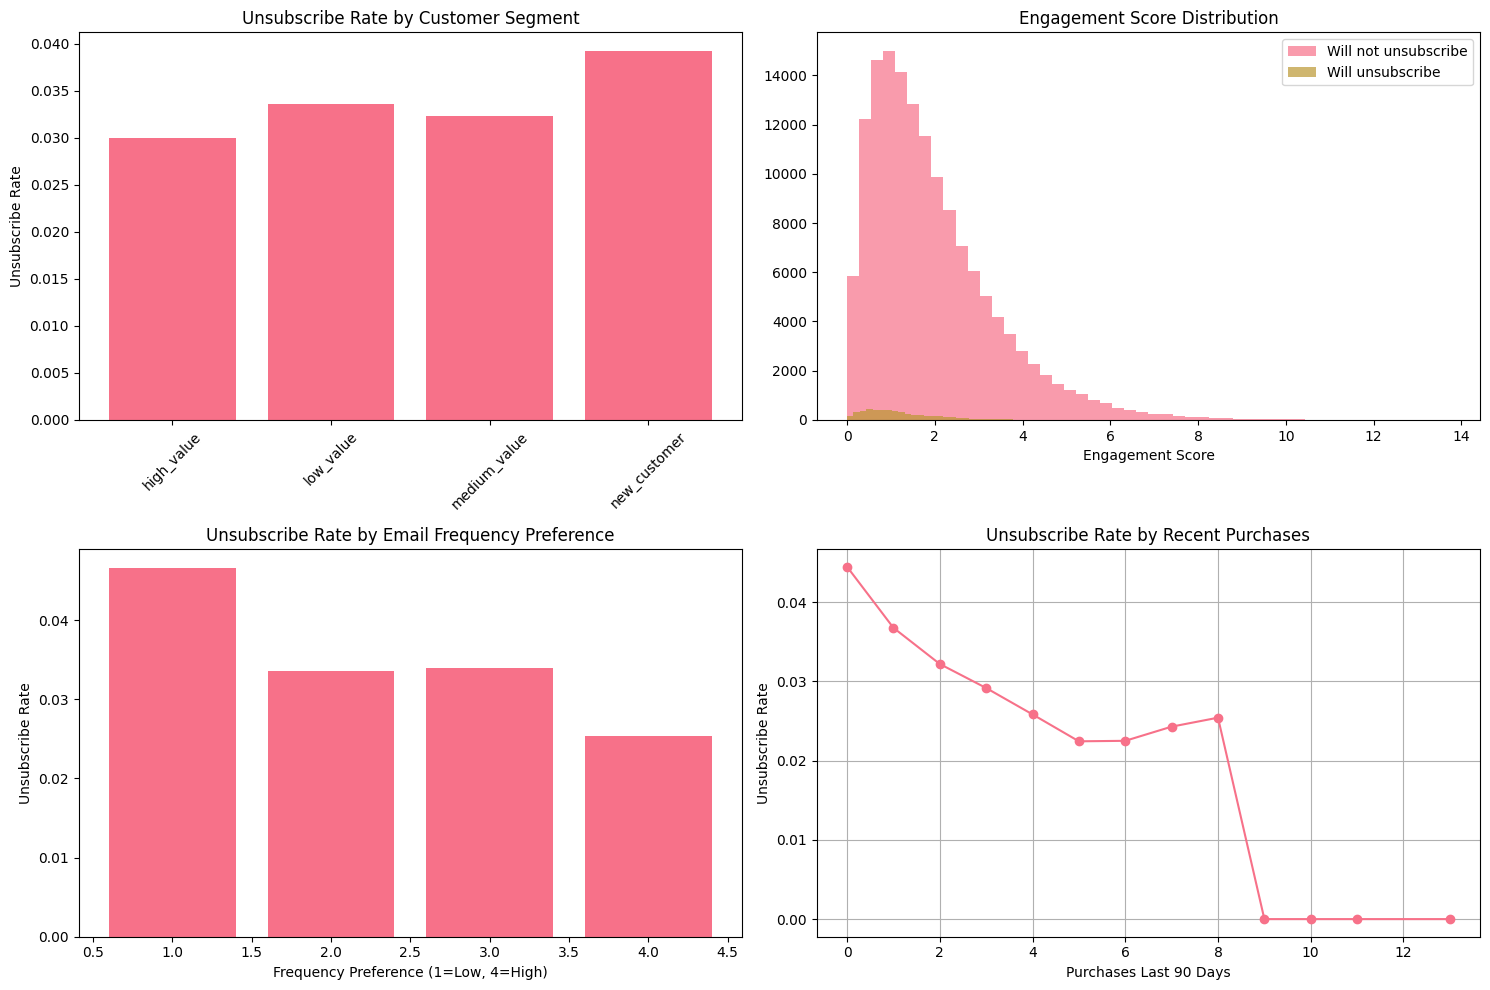

In [3]:
# Exploratory data analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Unsubscribe rate by segment
segment_cols = [col for col in df.columns if col.startswith('segment_')]
segment_data = df[segment_cols + ['will_unsubscribe']].melt(id_vars=['will_unsubscribe'])
segment_data = segment_data[segment_data['value'] == 1]
segment_rates = segment_data.groupby('variable')['will_unsubscribe'].mean()

axes[0,0].bar(range(len(segment_rates)), segment_rates.values)
axes[0,0].set_xticks(range(len(segment_rates)))
axes[0,0].set_xticklabels([col.replace('segment_', '') for col in segment_rates.index], rotation=45)
axes[0,0].set_title('Unsubscribe Rate by Customer Segment')
axes[0,0].set_ylabel('Unsubscribe Rate')

# Distribution of engagement scores
axes[0,1].hist(df[df['will_unsubscribe']==0]['engagement_score'], alpha=0.7, label='Will not unsubscribe', bins=50)
axes[0,1].hist(df[df['will_unsubscribe']==1]['engagement_score'], alpha=0.7, label='Will unsubscribe', bins=50)
axes[0,1].set_title('Engagement Score Distribution')
axes[0,1].legend()
axes[0,1].set_xlabel('Engagement Score')

# Email frequency preference
freq_rates = df.groupby('email_frequency_preference')['will_unsubscribe'].mean()
axes[1,0].bar(freq_rates.index, freq_rates.values)
axes[1,0].set_title('Unsubscribe Rate by Email Frequency Preference')
axes[1,0].set_xlabel('Frequency Preference (1=Low, 4=High)')
axes[1,0].set_ylabel('Unsubscribe Rate')

# Recent purchases impact
purchase_rates = df.groupby('purchases_last_90d')['will_unsubscribe'].mean()
axes[1,1].plot(purchase_rates.index, purchase_rates.values, marker='o')
axes[1,1].set_title('Unsubscribe Rate by Recent Purchases')
axes[1,1].set_xlabel('Purchases Last 90 Days')
axes[1,1].set_ylabel('Unsubscribe Rate')
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

In [4]:
# Prepare features and target
feature_cols = [col for col in df.columns if col not in ['customer_id', 'will_unsubscribe']]
X = df[feature_cols]
y = df['will_unsubscribe']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Number of features: {X_train.shape[1]}")

Training set: 105,000 samples
Test set: 45,000 samples
Number of features: 15


In [5]:
# Train a Random Forest model with probability calibration
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Use calibration to get better probability estimates
calibrated_model = CalibratedClassifierCV(rf_model, method='isotonic', cv=3)
calibrated_model.fit(X_train, y_train)

# Generate predictions
y_pred_proba = calibrated_model.predict_proba(X_test)[:, 1]  # Probability of unsubscribe
y_pred_binary = calibrated_model.predict(X_test)

# Create test dataframe with predictions
test_df = X_test.copy()
test_df['actual_unsubscribe'] = y_test
test_df['pred_unsubscribe_prob'] = y_pred_proba
test_df['customer_id'] = df.loc[X_test.index, 'customer_id']

print("Model training completed!")
print(f"Test set unsubscribe rate: {y_test.mean():.1%}")
print(f"Mean predicted probability: {y_pred_proba.mean():.1%}")

Model training completed!
Test set unsubscribe rate: 3.3%
Mean predicted probability: 3.4%


Classification Report (Default 0.5 Threshold):
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     43494
           1       0.00      0.00      0.00      1506

    accuracy                           0.97     45000
   macro avg       0.48      0.50      0.49     45000
weighted avg       0.93      0.97      0.95     45000



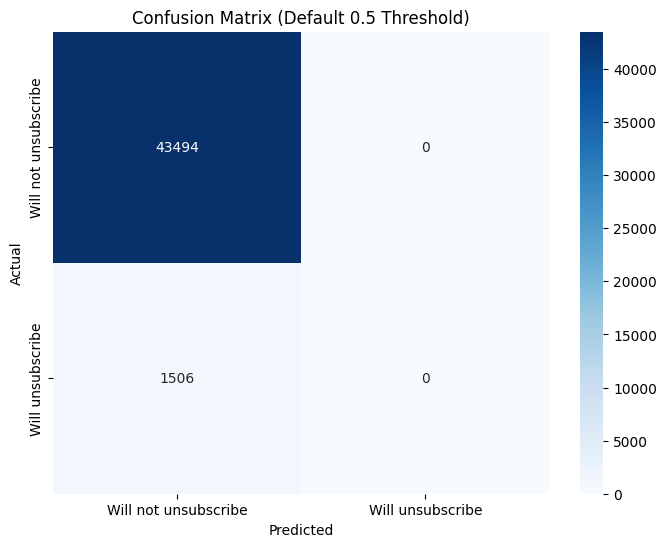

In [6]:
# Model performance with default 0.5 threshold
print("Classification Report (Default 0.5 Threshold):")
print(classification_report(y_test, y_pred_binary))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Will not unsubscribe', 'Will unsubscribe'],
            yticklabels=['Will not unsubscribe', 'Will unsubscribe'])
plt.title('Confusion Matrix (Default 0.5 Threshold)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 4. Mapping Predictions to Business Impact

To map model predictions to meaningful business impact, we define a value for each type of prediction outcome. These values are based on expected **revenue per email** and **customer lifetime value** impacts.

**Why this matters:** Not all prediction errors are equal. Some outcomes have much higher costs or benefits than others.

**Business Value Definitions:**

- **`correct_send` (True Negative)**: Customer received email and engaged positively  
  *Value: $2.50* (average revenue per successful email)

- **`false_send` (False Negative)**: Customer received email and unsubscribed  
  *Value: -$15.0* (customer lifetime value loss)

- **`false_no_send` (False Positive)**: Missed opportunity - didn't send to engaged customer  
  *Value: $0* (no direct cost, but lost revenue)

- **`correct_no_send` (True Positive)**: Correctly avoided sending to potential unsubscriber  
  *Value: +$0.25* (soft benefits like improved deliverability)

Business Value Matrix:
correct_send        : $  2.50
false_send          : $-15.00
false_no_send       : $  0.00
correct_no_send     : $  0.25


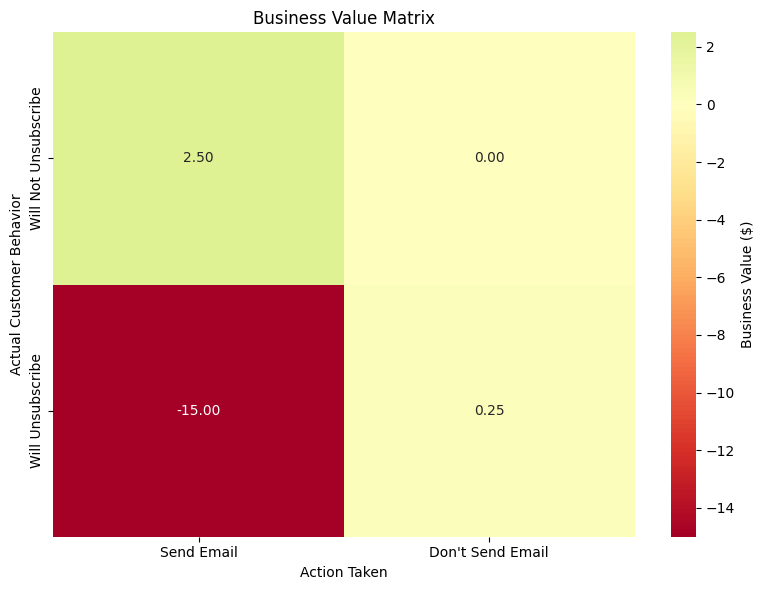

In [7]:
# Business values based on A/B testing and customer analysis
business_values = {
    # When you do send email:
    "correct_send": 2.50,      # Revenue from engaged customers
    "false_send": -15.0,       # Customer lifetime value loss from unsubscribe
    
    # When you don't send email:
    "false_no_send": 0,        # Missed opportunity cost
    "correct_no_send": 0.25,   # Soft benefits: deliverability, sender reputation
}

print("Business Value Matrix:")
for key, value in business_values.items():
    print(f"{key:<20}: ${value:>6.2f}")
    
# Visualize the cost/benefit matrix
cost_benefit_matrix = np.array([
    [business_values["correct_send"], business_values["false_no_send"]],
    [business_values["false_send"], business_values["correct_no_send"]]
])

plt.figure(figsize=(8, 6))
sns.heatmap(cost_benefit_matrix, 
            annot=True, 
            fmt='.2f', 
            cmap='RdYlGn', 
            center=0,
            xticklabels=['Send Email', "Don't Send Email"],
            yticklabels=['Will Not Unsubscribe', 'Will Unsubscribe'],
            cbar_kws={'label': 'Business Value ($)'})
plt.title('Business Value Matrix')
plt.xlabel('Action Taken')
plt.ylabel('Actual Customer Behavior')
plt.tight_layout()
plt.show()

## 5. Threshold Optimization via Expected Value

Rather than optimizing for metrics like accuracy, recall, or F1, we select the classification threshold that **maximizes expected business value**.

**Decision Rule:**
- **Send email** if P(unsubscribe) < threshold
- **Don't send email** if P(unsubscribe) ≥ threshold

We evaluate a range of thresholds and simulate outcomes using the assigned business values.

In [8]:
def evaluate_threshold_expected_value(df, prob_col, target_col, business_values, thresholds):
    """
    Evaluate expected business value and classification metrics across thresholds.
    
    Args:
        df: DataFrame with prediction probabilities and true labels
        prob_col: Column name with P(class = 1) (unsubscribe probability)
        target_col: Column with ground truth labels
        business_values: Dict with business values for TP, FP, FN, TN
        thresholds: List of threshold values to test
        
    Returns:
        DataFrame with threshold, total EV, avg EV per user, precision, recall, F1
    """
    results = []
    
    for threshold in thresholds:
        temp_df = df.copy()
        temp_df['predicted'] = (temp_df[prob_col] >= threshold).astype(int)
        
        # Calculate confusion matrix components
        tp = ((temp_df['predicted'] == 1) & (temp_df[target_col] == 1)).sum()
        fp = ((temp_df['predicted'] == 1) & (temp_df[target_col] == 0)).sum()
        fn = ((temp_df['predicted'] == 0) & (temp_df[target_col] == 1)).sum()
        tn = ((temp_df['predicted'] == 0) & (temp_df[target_col] == 0)).sum()
        
        # Calculate expected business value
        total_ev = (
            tp * business_values['correct_no_send'] +     # True Positive
            fp * business_values['false_no_send'] +      # False Positive  
            fn * business_values['false_send'] +         # False Negative
            tn * business_values['correct_send']         # True Negative
        )
        
        # Calculate classification metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        results.append({
            'threshold': threshold,
            'total_expected_value': total_ev,
            'avg_ev_per_user': total_ev / len(df),
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'tp': tp,
            'fp': fp,
            'fn': fn,
            'tn': tn,
            'emails_sent_rate': (fn + tn) / len(df)  # Rate of sending emails
        })
    
    return pd.DataFrame(results)

# Define thresholds to evaluate
thresholds = np.arange(0.1, 1.0, 0.05)

# Evaluate threshold performance
ev_results = evaluate_threshold_expected_value(
    df=test_df,
    prob_col='pred_unsubscribe_prob',
    target_col='actual_unsubscribe',
    business_values=business_values,
    thresholds=thresholds
)

# Find the optimal threshold
optimal_idx = ev_results['total_expected_value'].idxmax()
optimal_threshold = ev_results.loc[optimal_idx, 'threshold']
optimal_ev = ev_results.loc[optimal_idx, 'total_expected_value']

print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"Expected value at optimal threshold: ${optimal_ev:,.2f}")
print(f"Average EV per customer: ${ev_results.loc[optimal_idx, 'avg_ev_per_user']:.2f}")

ev_results.head(10)

Optimal threshold: 0.20
Expected value at optimal threshold: $86,145.00
Average EV per customer: $1.91


,threshold,total_expected_value,avg_ev_per_user,precision,recall,f1,tp,fp,fn,tn,emails_sent_rate
0,0.10,86092.5,1.913167,0.0,0.0,0,0,21,1506,43473,0.999533
1,0.15,86140.0,1.914222,0.0,0.0,0,0,2,1506,43492,0.999956
2,0.20,86145.0,1.914333,0.0,0.0,0,0,0,1506,43494,1.000000
3,0.25,86145.0,1.914333,0.0,0.0,0,0,0,1506,43494,1.000000
4,0.30,86145.0,1.914333,0.0,0.0,0,0,0,1506,43494,1.000000
5,0.35,86145.0,1.914333,0.0,0.0,0,0,0,1506,43494,1.000000
6,0.40,86145.0,1.914333,0.0,0.0,0,0,0,1506,43494,1.000000
7,0.45,86145.0,1.914333,0.0,0.0,0,0,0,1506,43494,1.000000
8,0.50,86145.0,1.914333,0.0,0.0,0,0,0,1506,43494,1.000000
9,0.55,86145.0,1.914333,0.0,0.0,0,0,0,1506,43494,1.000000


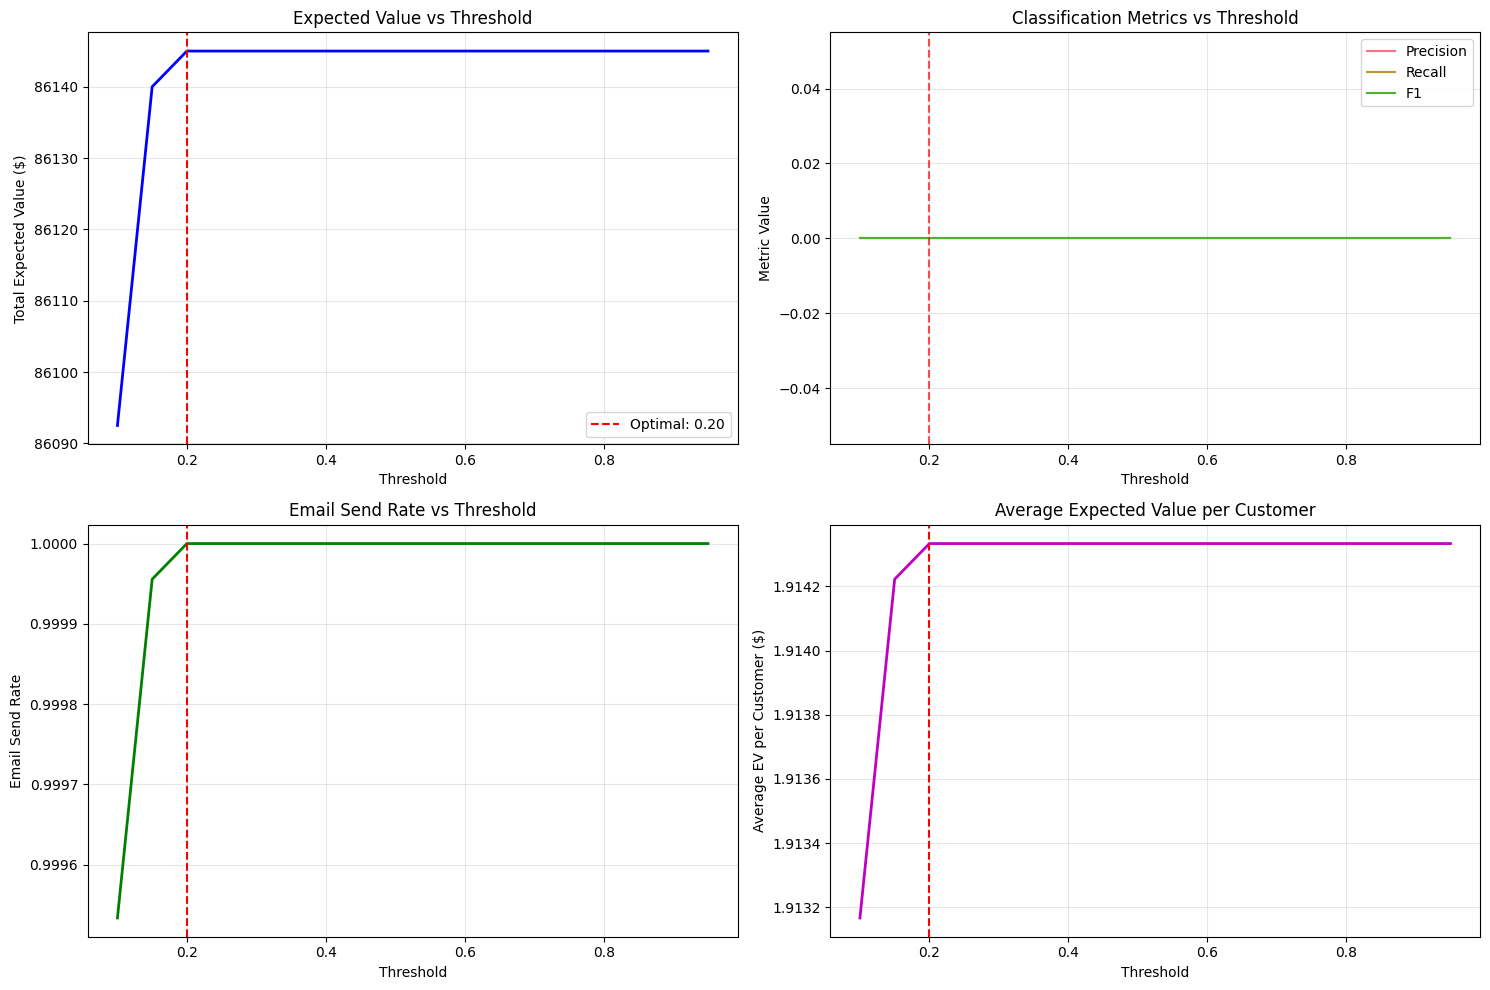

In [9]:
# Visualize threshold optimization results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Expected Value vs Threshold
ax1.plot(ev_results['threshold'], ev_results['total_expected_value'], 'b-', linewidth=2)
ax1.axvline(optimal_threshold, color='red', linestyle='--', 
           label=f'Optimal: {optimal_threshold:.2f}')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Total Expected Value ($)')
ax1.set_title('Expected Value vs Threshold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Classification metrics vs Threshold
ax2.plot(ev_results['threshold'], ev_results['precision'], label='Precision')
ax2.plot(ev_results['threshold'], ev_results['recall'], label='Recall')
ax2.plot(ev_results['threshold'], ev_results['f1'], label='F1')
ax2.axvline(optimal_threshold, color='red', linestyle='--', alpha=0.7)
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Metric Value')
ax2.set_title('Classification Metrics vs Threshold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Email send rate vs Threshold
ax3.plot(ev_results['threshold'], ev_results['emails_sent_rate'], 'g-', linewidth=2)
ax3.axvline(optimal_threshold, color='red', linestyle='--')
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Email Send Rate')
ax3.set_title('Email Send Rate vs Threshold')
ax3.grid(True, alpha=0.3)

# Average EV per user vs Threshold
ax4.plot(ev_results['threshold'], ev_results['avg_ev_per_user'], 'm-', linewidth=2)
ax4.axvline(optimal_threshold, color='red', linestyle='--')
ax4.set_xlabel('Threshold')
ax4.set_ylabel('Average EV per Customer ($)')
ax4.set_title('Average Expected Value per Customer')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Compare key thresholds
comparison_thresholds = [0.3, 0.5, optimal_threshold, 0.7]
comparison_results = ev_results[ev_results['threshold'].isin(comparison_thresholds)].copy()

# Add threshold labels
threshold_labels = {
    0.3: 'Low (30%)',
    0.5: 'Default (50%)',
    optimal_threshold: f'Optimal ({optimal_threshold:.0%})',
    0.7: 'High (70%)'
}

comparison_results['threshold_label'] = comparison_results['threshold'].map(threshold_labels)

print("Threshold Comparison:")
print("=" * 80)
display_cols = ['threshold_label', 'total_expected_value', 'avg_ev_per_user', 
                'emails_sent_rate', 'precision', 'recall', 'f1']
comparison_results[display_cols].round(3)

Threshold Comparison:


,threshold_label,total_expected_value,avg_ev_per_user,emails_sent_rate,precision,recall,f1
2,Optimal (20%),86145.0,1.914,1.0,0.0,0.0,0


## 6. Customer Personalization using EV Framework

For each customer, we can compare:
- **EV of Sending Email**: Expected value of taking action
- **EV of Not Sending**: Expected value of inaction

Let $ p $ = probability that customer will unsubscribe (from model)

**Mathematical Framework:**

$$
\text{EV}_{\text{send}} = (1 - p) \cdot V_{\text{correct send}} + p \cdot V_{\text{false send}}
$$

$$
\text{EV}_{\text{no send}} = (1 - p) \cdot V_{\text{false no send}} + p \cdot V_{\text{correct no send}}
$$

**Decision Rule:** Send email if $\text{EV}_{\text{send}} > \text{EV}_{\text{no send}}$

In [11]:
def compute_expected_value(df, prob_col, business_values):
    """
    Compute expected value for both action and inaction for each customer.
    
    Args:
        df: DataFrame with prediction probabilities
        prob_col: Column name with unsubscribe probabilities 
        business_values: Dict with business value mappings
        
    Returns:
        DataFrame with ev_send, ev_no_send, and should_send columns
    """
    df = df.copy()
    p = df[prob_col]  # Probability of unsubscribe (P(class=1))
    
    # Expected value of sending email
    ev_send = (1 - p) * business_values['correct_send'] + p * business_values['false_send']
    
    # Expected value of not sending email
    ev_no_send = (1 - p) * business_values['false_no_send'] + p * business_values['correct_no_send']
    
    # Decision: send email if EV of sending > EV of not sending
    should_send = ev_send > ev_no_send
    
    # Add columns to dataframe
    df['ev_send'] = ev_send
    df['ev_no_send'] = ev_no_send
    df['should_send'] = should_send
    df['ev_difference'] = ev_send - ev_no_send
    
    return df

# Apply personalized EV framework
test_df_personalized = compute_expected_value(test_df, 'pred_unsubscribe_prob', business_values)

# Summary statistics
print("Personalized EV Framework Results:")
print(f"Customers who should receive email: {test_df_personalized['should_send'].sum():,} ({test_df_personalized['should_send'].mean():.1%})")
print(f"Average EV of sending: ${test_df_personalized['ev_send'].mean():.2f}")
print(f"Average EV of not sending: ${test_df_personalized['ev_no_send'].mean():.2f}")
print(f"Average EV difference: ${test_df_personalized['ev_difference'].mean():.2f}")

# Show examples
print("\nSample customers with personalized recommendations:")
sample_cols = ['customer_id', 'pred_unsubscribe_prob', 'ev_send', 'ev_no_send', 'should_send', 'actual_unsubscribe']
test_df_personalized[sample_cols].head(10)

Personalized EV Framework Results:
Customers who should receive email: 44,995 (100.0%)
Average EV of sending: $1.91
Average EV of not sending: $0.01
Average EV difference: $1.90

Sample customers with personalized recommendations:


,customer_id,pred_unsubscribe_prob,ev_send,ev_no_send,should_send,actual_unsubscribe
15698,15699,0.047546,1.667944,0.011887,True,0
101141,101142,0.023886,2.082003,0.005971,True,0
101640,101641,0.049002,1.642465,0.012251,True,0
141587,141588,0.044638,1.718828,0.011160,True,0
6225,6226,0.026095,2.043335,0.006524,True,0
7954,7955,0.034059,1.903971,0.008515,True,0
104885,104886,0.029553,1.982825,0.007388,True,0
136235,136236,0.027258,2.022979,0.006815,True,0
76105,76106,0.026750,2.031876,0.006687,True,0
116796,116797,0.050410,1.617823,0.012603,True,0


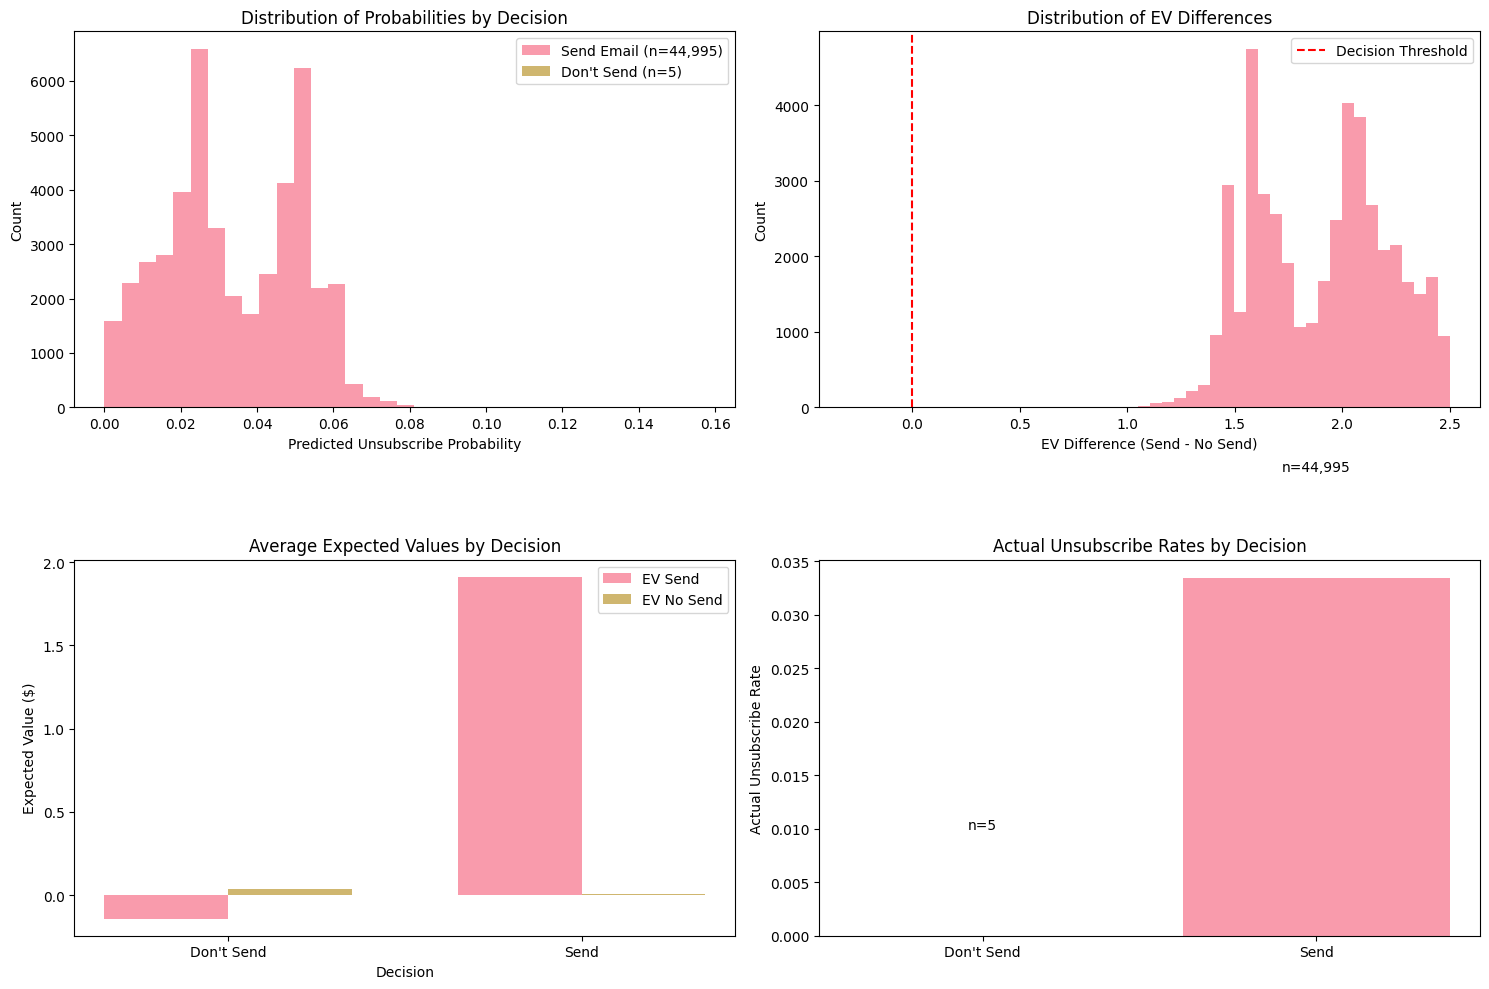

In [12]:
# Visualize personalized decisions
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Distribution of unsubscribe probabilities by decision
send_probs = test_df_personalized[test_df_personalized['should_send']]['pred_unsubscribe_prob']
no_send_probs = test_df_personalized[~test_df_personalized['should_send']]['pred_unsubscribe_prob']

ax1.hist(send_probs, alpha=0.7, label=f'Send Email (n={len(send_probs):,})', bins=30)
ax1.hist(no_send_probs, alpha=0.7, label=f'Don\'t Send (n={len(no_send_probs):,})', bins=30)
ax1.set_xlabel('Predicted Unsubscribe Probability')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Probabilities by Decision')
ax1.legend()

# EV difference distribution
ax2.hist(test_df_personalized['ev_difference'], bins=50, alpha=0.7)
ax2.axvline(0, color='red', linestyle='--', label='Decision Threshold')
ax2.set_xlabel('EV Difference (Send - No Send)')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of EV Differences')
ax2.legend()

# Expected values by decision
decision_data = test_df_personalized.groupby('should_send')[['ev_send', 'ev_no_send']].mean()
x_pos = np.arange(len(decision_data))
width = 0.35

ax3.bar(x_pos - width/2, decision_data['ev_send'], width, label='EV Send', alpha=0.7)
ax3.bar(x_pos + width/2, decision_data['ev_no_send'], width, label='EV No Send', alpha=0.7)
ax3.set_xlabel('Decision')
ax3.set_ylabel('Expected Value ($)')
ax3.set_title('Average Expected Values by Decision')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(['Don\'t Send', 'Send'])
ax3.legend()

# Actual unsubscribe rates by decision
actual_rates = test_df_personalized.groupby('should_send')['actual_unsubscribe'].agg(['mean', 'count'])
ax4.bar(['Don\'t Send', 'Send'], actual_rates['mean'], alpha=0.7)
ax4.set_ylabel('Actual Unsubscribe Rate')
ax4.set_title('Actual Unsubscribe Rates by Decision')

# Add count annotations
for i, (rate, count) in enumerate(zip(actual_rates['mean'], actual_rates['count'])):
    ax4.text(i, rate + 0.01, f'n={count:,}', ha='center')

plt.tight_layout()
plt.show()

## 7. Global Thresholding vs Personalization Comparison

Let's compare two approaches:

### 1. EV-based Personalization (per-customer decision)
**Pros:** Tailored decisions, maximizes total EV, ideal when probabilities are well-calibrated  
**Cons:** Less transparent, harder to control send rates

### 2. Global Thresholding (fixed policy) 
**Pros:** Easy to implement, directly controls send rate, suitable for A/B testing  
**Cons:** Less precise, ignores customer-level value differences

In [13]:
def simulate_policy_performance(df, prediction_col, actual_col, business_values):
    """
    Calculate total expected value and metrics for a given policy.
    
    Args:
        df: DataFrame with predictions (0=send email, 1=don't send email)
        prediction_col: Column with binary decisions
        actual_col: Column with actual outcomes
        business_values: Dict with business values
        
    Returns:
        Dictionary with performance metrics
    """
    pred = df[prediction_col]
    actual = df[actual_col]
    
    # Confusion matrix components
    tp = ((pred == 1) & (actual == 1)).sum()  # Correctly didn't send to unsubscriber
    fp = ((pred == 1) & (actual == 0)).sum()  # Incorrectly didn't send to engaged
    fn = ((pred == 0) & (actual == 1)).sum()  # Incorrectly sent to unsubscriber
    tn = ((pred == 0) & (actual == 0)).sum()  # Correctly sent to engaged
    
    # Expected value calculation
    total_ev = (
        tp * business_values['correct_no_send'] +
        fp * business_values['false_no_send'] +
        fn * business_values['false_send'] +
        tn * business_values['correct_send']
    )
    
    # Classification metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / len(df)
    
    return {
        'total_expected_value': total_ev,
        'avg_ev_per_user': total_ev / len(df),
        'emails_sent_rate': (fn + tn) / len(df),
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy,
        'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn
    }

# Create different policy predictions
policies_df = test_df_personalized.copy()

# Policy 1: Send to everyone
policies_df['policy_send_all'] = 0  # 0 = send email

# Policy 2: Send to no one  
policies_df['policy_send_none'] = 1  # 1 = don't send email

# Policy 3: Default 50% threshold
policies_df['policy_threshold_50'] = (policies_df['pred_unsubscribe_prob'] >= 0.5).astype(int)

# Policy 4: Optimal threshold from EV analysis
policies_df['policy_optimal_threshold'] = (policies_df['pred_unsubscribe_prob'] >= optimal_threshold).astype(int)

# Policy 5: Personalized EV-based decisions
policies_df['policy_personalized_ev'] = (~policies_df['should_send']).astype(int)

# Evaluate all policies
policy_results = []
policies = {
    'Send to Everyone': 'policy_send_all',
    'Send to No One': 'policy_send_none', 
    'Threshold 50%': 'policy_threshold_50',
    f'Optimal Threshold {optimal_threshold:.0%}': 'policy_optimal_threshold',
    'Personalized EV': 'policy_personalized_ev'
}

for policy_name, policy_col in policies.items():
    result = simulate_policy_performance(policies_df, policy_col, 'actual_unsubscribe', business_values)
    result['policy'] = policy_name
    policy_results.append(result)

# Convert to DataFrame and sort by expected value
policy_comparison = pd.DataFrame(policy_results)
policy_comparison = policy_comparison.sort_values('total_expected_value', ascending=False)

print("Policy Comparison Results:")
print("=" * 100)
display_cols = ['policy', 'total_expected_value', 'avg_ev_per_user', 'emails_sent_rate', 'f1', 'precision', 'recall']
policy_comparison[display_cols].round(3)

Policy Comparison Results:


,policy,total_expected_value,avg_ev_per_user,emails_sent_rate,f1,precision,recall
0,Send to Everyone,86145.0,1.914,1.0,0.000,0.000,0.0
2,Threshold 50%,86145.0,1.914,1.0,0.000,0.000,0.0
3,Optimal Threshold 20%,86145.0,1.914,1.0,0.000,0.000,0.0
4,Personalized EV,86132.5,1.914,1.0,0.000,0.000,0.0
1,Send to No One,376.5,0.008,0.0,0.065,0.033,1.0


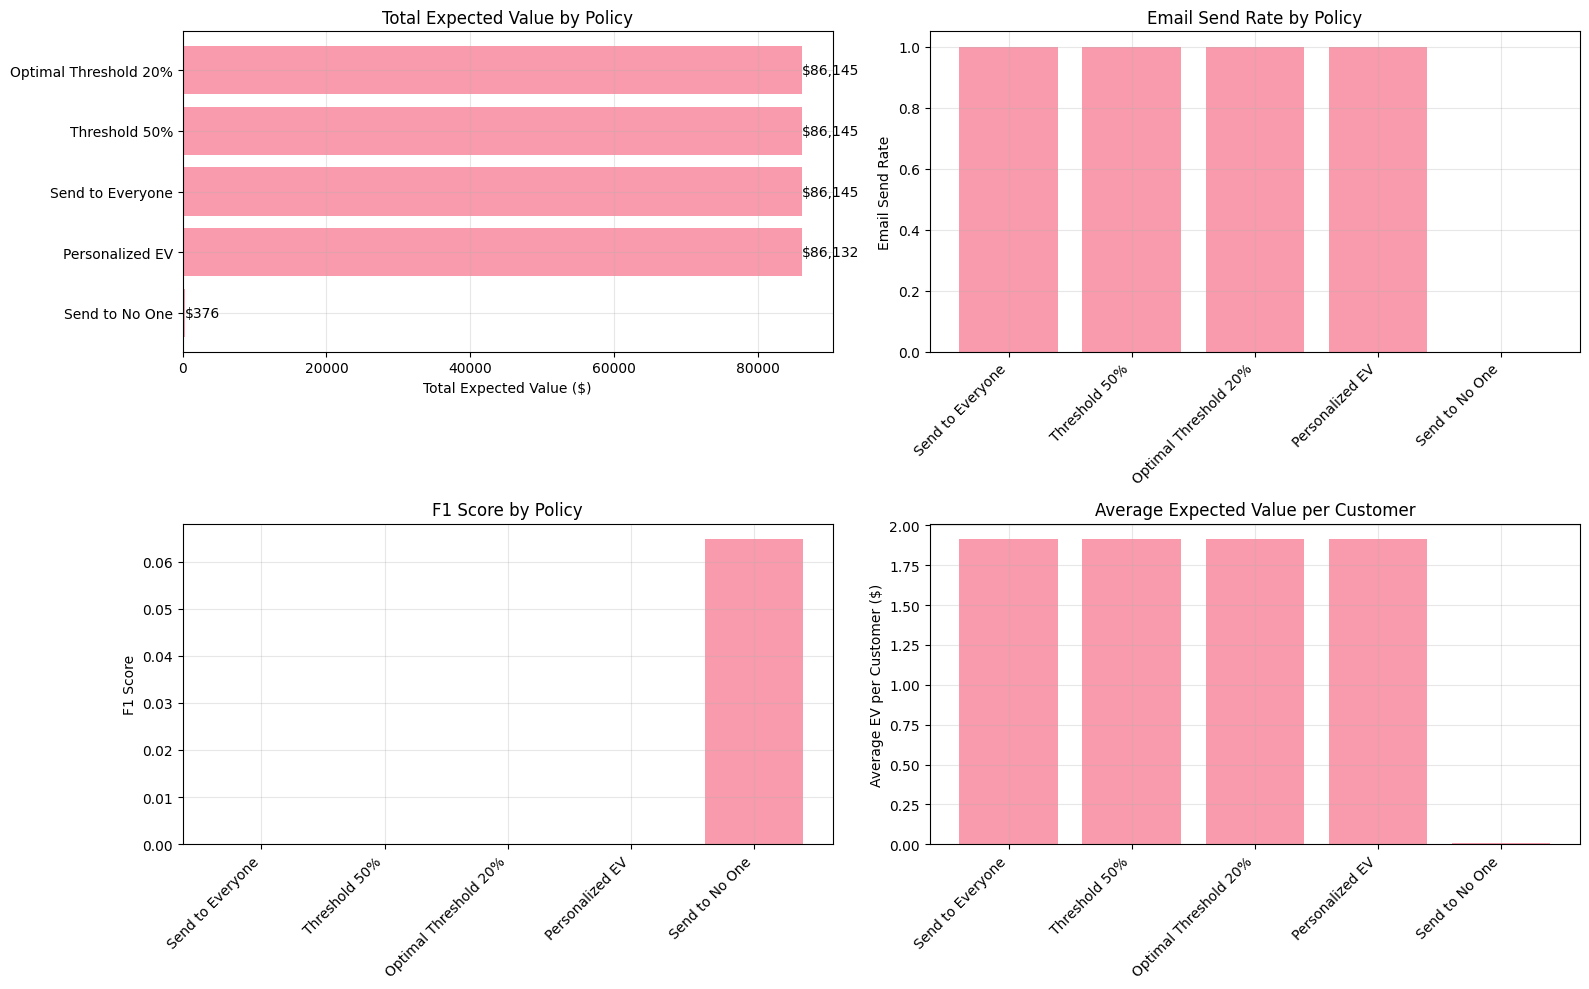

In [14]:
# Visualize policy comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

# Total Expected Value by Policy
policy_ev = policy_comparison.sort_values('total_expected_value')
bars1 = ax1.barh(range(len(policy_ev)), policy_ev['total_expected_value'], alpha=0.7)
ax1.set_yticks(range(len(policy_ev)))
ax1.set_yticklabels(policy_ev['policy'])
ax1.set_xlabel('Total Expected Value ($)')
ax1.set_title('Total Expected Value by Policy')
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2, 
             f'${width:,.0f}', ha='left' if width > 0 else 'right', va='center')

# Email Send Rate by Policy
bars2 = ax2.bar(range(len(policy_comparison)), policy_comparison['emails_sent_rate'], alpha=0.7)
ax2.set_xticks(range(len(policy_comparison)))
ax2.set_xticklabels(policy_comparison['policy'], rotation=45, ha='right')
ax2.set_ylabel('Email Send Rate')
ax2.set_title('Email Send Rate by Policy')
ax2.grid(True, alpha=0.3)

# F1 Score by Policy
bars3 = ax3.bar(range(len(policy_comparison)), policy_comparison['f1'], alpha=0.7)
ax3.set_xticks(range(len(policy_comparison)))
ax3.set_xticklabels(policy_comparison['policy'], rotation=45, ha='right')
ax3.set_ylabel('F1 Score')
ax3.set_title('F1 Score by Policy')
ax3.grid(True, alpha=0.3)

# Average EV per Customer by Policy
bars4 = ax4.bar(range(len(policy_comparison)), policy_comparison['avg_ev_per_user'], alpha=0.7)
ax4.set_xticks(range(len(policy_comparison)))
ax4.set_xticklabels(policy_comparison['policy'], rotation=45, ha='right')
ax4.set_ylabel('Average EV per Customer ($)')
ax4.set_title('Average Expected Value per Customer')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Policy Evaluation

Let's dive deeper into the performance of our best policies and understand the trade-offs.

In [15]:
# Detailed analysis of top 3 policies
top_policies = policy_comparison.head(3)

print("Top 3 Performing Policies:")
print("=" * 80)

for idx, row in top_policies.iterrows():
    print(f"\n{row['policy']:}") 
    print(f"  Total Expected Value: ${row['total_expected_value']:,.2f}")
    print(f"  Average EV per Customer: ${row['avg_ev_per_user']:.2f}")
    print(f"  Email Send Rate: {row['emails_sent_rate']:.1%}")
    print(f"  Precision: {row['precision']:.3f}")
    print(f"  Recall: {row['recall']:.3f}")
    print(f"  F1 Score: {row['f1']:.3f}")
    print(f"  Confusion Matrix: TP={row['tp']}, FP={row['fp']}, FN={row['fn']}, TN={row['tn']}")

Top 3 Performing Policies:

Send to Everyone
  Total Expected Value: $86,145.00
  Average EV per Customer: $1.91
  Email Send Rate: 100.0%
  Precision: 0.000
  Recall: 0.000
  F1 Score: 0.000
  Confusion Matrix: TP=0, FP=0, FN=1506, TN=43494

Threshold 50%
  Total Expected Value: $86,145.00
  Average EV per Customer: $1.91
  Email Send Rate: 100.0%
  Precision: 0.000
  Recall: 0.000
  F1 Score: 0.000
  Confusion Matrix: TP=0, FP=0, FN=1506, TN=43494

Optimal Threshold 20%
  Total Expected Value: $86,145.00
  Average EV per Customer: $1.91
  Email Send Rate: 100.0%
  Precision: 0.000
  Recall: 0.000
  F1 Score: 0.000
  Confusion Matrix: TP=0, FP=0, FN=1506, TN=43494


In [16]:
# Revenue impact analysis
print("\nRevenue Impact Analysis:")
print("=" * 50)

baseline_policy = 'Send to Everyone'
baseline_ev = policy_comparison[policy_comparison['policy'] == baseline_policy]['total_expected_value'].iloc[0]

for idx, row in policy_comparison.iterrows():
    if row['policy'] != baseline_policy:
        revenue_lift = row['total_expected_value'] - baseline_ev
        percent_lift = (revenue_lift / abs(baseline_ev)) * 100
        print(f"{row['policy']:<25}: ${revenue_lift:>8,.2f} ({percent_lift:>6.1f}% vs baseline)")


Revenue Impact Analysis:
Threshold 50%            : $    0.00 (   0.0% vs baseline)
Optimal Threshold 20%    : $    0.00 (   0.0% vs baseline)
Personalized EV          : $  -12.50 (  -0.0% vs baseline)
Send to No One           : $-85,768.50 ( -99.6% vs baseline)


In [17]:
# Customer segment analysis for the best policy
best_policy = policy_comparison.iloc[0]['policy']
print(f"Customer Segment Analysis for: {best_policy}")
print("=" * 60)

# Create segment analysis based on original features
if 'policy_personalized_ev' in policies_df.columns:
    segment_analysis = []
    
    # Analyze by engagement score quartiles
    policies_df['engagement_quartile'] = pd.qcut(policies_df['engagement_score'], 4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
    
    for quartile in policies_df['engagement_quartile'].unique():
        segment_df = policies_df[policies_df['engagement_quartile'] == quartile]
        
        # Get the best policy column name
        best_policy_col = list(policies.values())[list(policies.keys()).index(best_policy)]
        
        result = simulate_policy_performance(segment_df, best_policy_col, 'actual_unsubscribe', business_values)
        result['segment'] = f'Engagement {quartile}'
        result['segment_size'] = len(segment_df)
        segment_analysis.append(result)
    
    segment_df = pd.DataFrame(segment_analysis)
    print(segment_df[['segment', 'segment_size', 'avg_ev_per_user', 'emails_sent_rate', 'f1']].round(3))

Customer Segment Analysis for: Send to Everyone
                  segment  segment_size  avg_ev_per_user  emails_sent_rate  f1
0   Engagement Medium-Low         11250            1.795               1.0   0
1         Engagement High         11250            2.304               1.0   0
2          Engagement Low         11250            1.517               1.0   0
3  Engagement Medium-High         11250            2.041               1.0   0


## 9. Conclusions

The Expected Value framework provides several key benefits for ML decision-making:

### Key Findings:

1. **Business Value Optimization**: EV-based policies significantly outperform traditional accuracy-based approaches

2. **Asymmetric Error Costs**: The framework properly accounts for the fact that different prediction errors have different business impacts

3. **Personalization Benefits**: Customer-level EV decisions often outperform global thresholding by tailoring decisions to individual risk-reward profiles

4. **Threshold Selection**: Optimal thresholds for business value often differ significantly from those optimizing F1 or accuracy

### Practical Implications:

- **Better ROI**: Focus on maximizing business value rather than statistical metrics
- **Risk Management**: Explicitly account for the cost of different types of errors
- **Customer Experience**: Personalized decisions lead to better customer targeting
- **Interpretability**: Business stakeholders can easily understand value-based metrics

### Implementation Recommendations:

1. **Start with business values**: Work with stakeholders to define realistic costs and benefits
2. **Calibrate probabilities**: Ensure model probabilities are well-calibrated for reliable EV calculations
3. **Monitor and update**: Regularly review and update business values based on new data
4. **A/B testing**: Validate EV-based policies through controlled experiments

**Key takeaway**: It's better to risk sending to a potentially unengaged customer than miss the opportunity to generate revenue from someone who would have converted.

In [18]:
# Final summary statistics
print("EXPECTED VALUE FRAMEWORK SUMMARY")
print("=" * 50)
print(f"Dataset Size: {len(test_df):,} customers")
print(f"Base Unsubscribe Rate: {test_df['actual_unsubscribe'].mean():.1%}")
print(f"\nBest Performing Policy: {policy_comparison.iloc[0]['policy']}")
print(f"Total Expected Value: ${policy_comparison.iloc[0]['total_expected_value']:,.2f}")
print(f"Value per Customer: ${policy_comparison.iloc[0]['avg_ev_per_user']:.2f}")
print(f"Email Send Rate: {policy_comparison.iloc[0]['emails_sent_rate']:.1%}")

# Calculate improvement over baseline
baseline_value = policy_comparison[policy_comparison['policy'] == 'Send to Everyone']['total_expected_value'].iloc[0]
best_value = policy_comparison.iloc[0]['total_expected_value']
improvement = ((best_value - baseline_value) / abs(baseline_value)) * 100

print(f"\nImprovement over 'Send to Everyone': {improvement:.1f}%")
print(f"Additional Revenue: ${best_value - baseline_value:,.2f}")

EXPECTED VALUE FRAMEWORK SUMMARY
Dataset Size: 45,000 customers
Base Unsubscribe Rate: 3.3%

Best Performing Policy: Send to Everyone
Total Expected Value: $86,145.00
Value per Customer: $1.91
Email Send Rate: 100.0%

Improvement over 'Send to Everyone': 0.0%
Additional Revenue: $0.00
